# Basic Concepts of Machine Learning and Overview of Classic Machine Learning Strategies

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

import matplotlib.pyplot as plt
plt.xkcd()

Populating the interactive namespace from numpy and matplotlib


# Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26783  100 26783    0     0  74604      0 --:--:-- --:--:-- --:--:-- 74604


In [3]:
import pandas as pd
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [4]:
df.head()

speed   age  miles  group
0   98.0  44.0   25.0      1
1  118.0  54.0   24.0      1
2  111.0  26.0   34.0      0
3   97.0  25.0   10.0      2
4  114.0  38.0   22.0      1

In [5]:
df.describe()

speed          age        miles        group
count  1500.000000  1500.000000  1500.000000  1500.000000
mean    122.492667    44.980667    30.434000     0.998667
std      17.604333    17.130400    15.250815     0.816768
min      68.000000    16.000000     1.000000     0.000000
25%     108.000000    32.000000    18.000000     0.000000
50%     120.000000    42.000000    29.000000     1.000000
75%     137.000000    55.000000    42.000000     2.000000
max     166.000000   100.000000    84.000000     2.000000

## A pairplot gives you a nice overview of your data with just a few lines of code

In [6]:
sns.pairplot?

Object `sns.pairplot` not found.


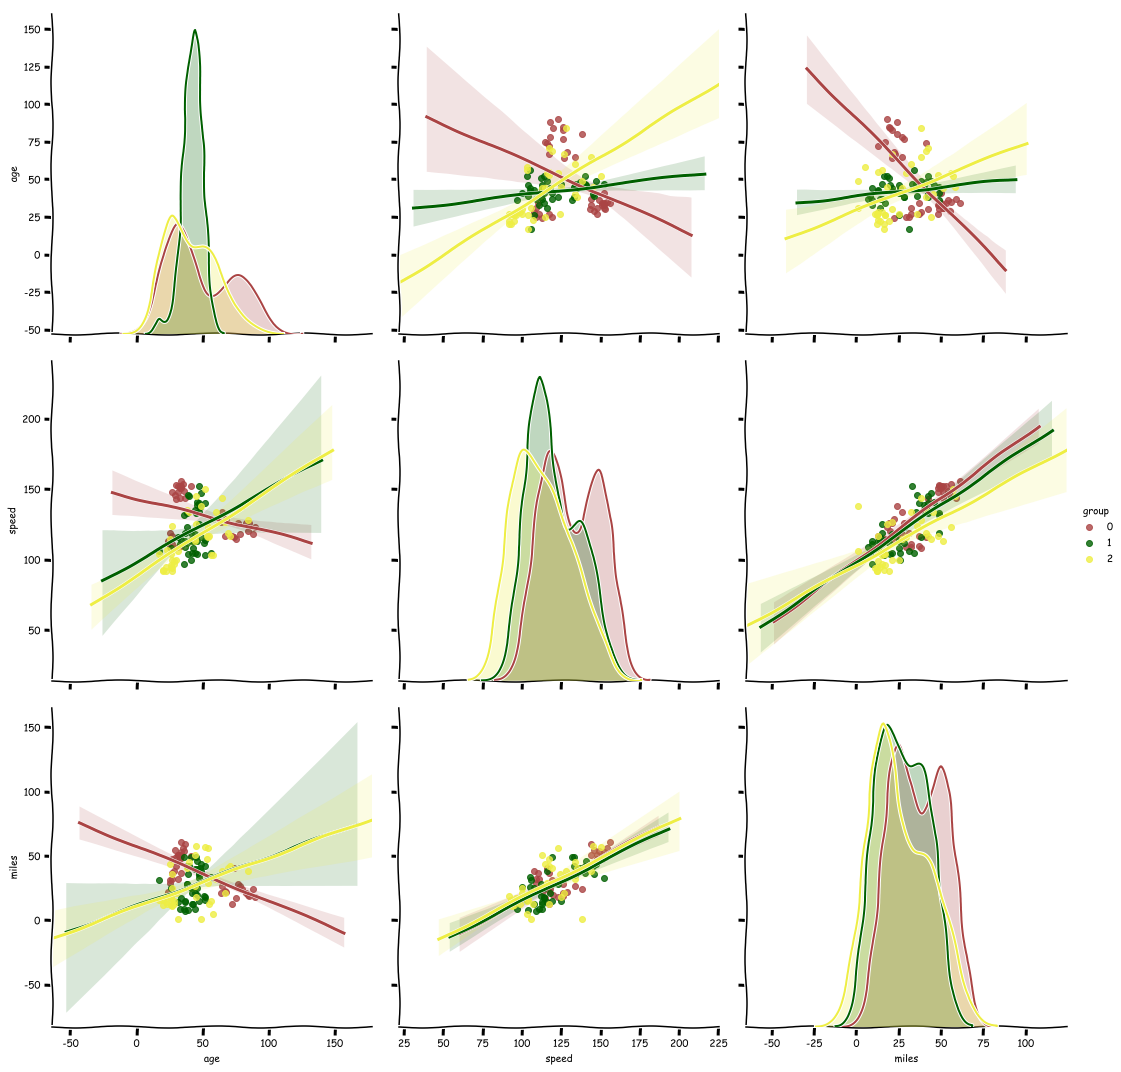

In [7]:
import seaborn as sns

sample_df = df.sample(n=120, random_state=42)
sns.pairplot(sample_df, 
             height=5,
             hue="group", palette={0: '#AA4444', 1: '#006000', 2: '#EEEE44'},
             kind='reg',
             diag_kind='kde', vars=['age', 'speed', 'miles'])

# Concepts

## First important concept: You train a machine with your data to make it learn the relationship between some input data and a certain label - this is called supervised learning

In [8]:
# we deliberately decide this is going to be our label, it is often called lower case y
y=df['group']

In [9]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [10]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.as_matrix()

### We restrict ourselves to two dimensions for now

Because this is all we really can visualize in 2d

In [11]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   mesh=True, fname=None):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

def plot_keras_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_    

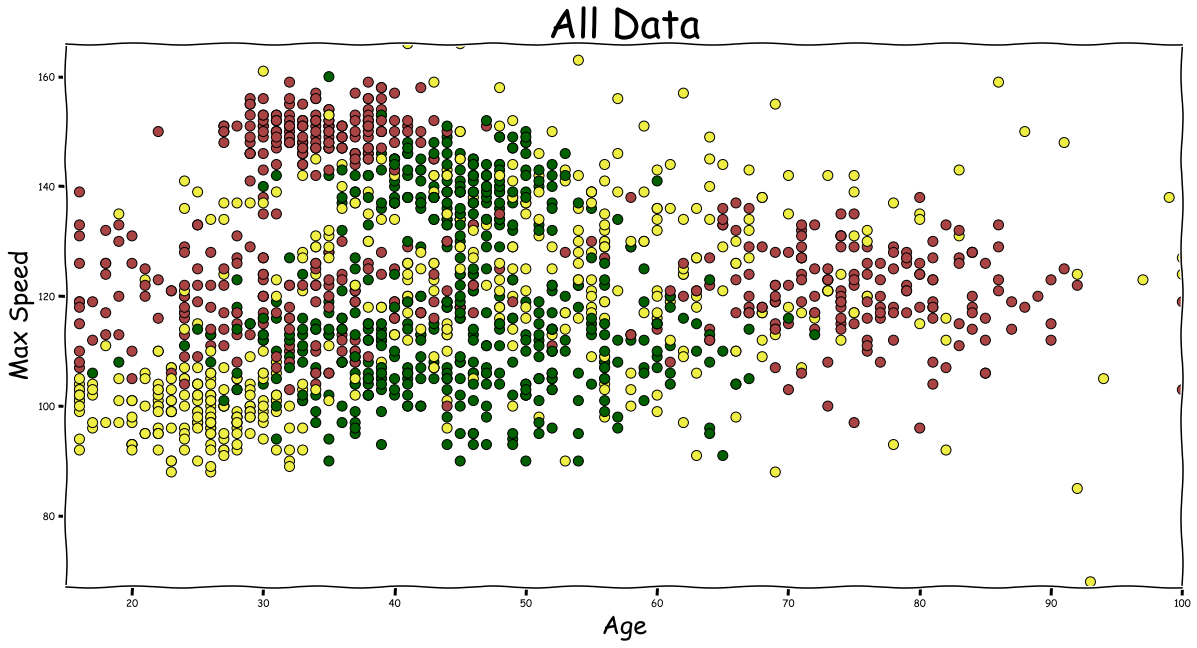

In [12]:
plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y, mesh=False,
                title="All Data",
                fname='all.png')

## Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/generalization.jpg'>

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# using stratefy we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [16]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2], dtype=int64), array([301, 300, 299], dtype=int64))

In [17]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2], dtype=int64), array([200, 200, 200], dtype=int64))

In [18]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

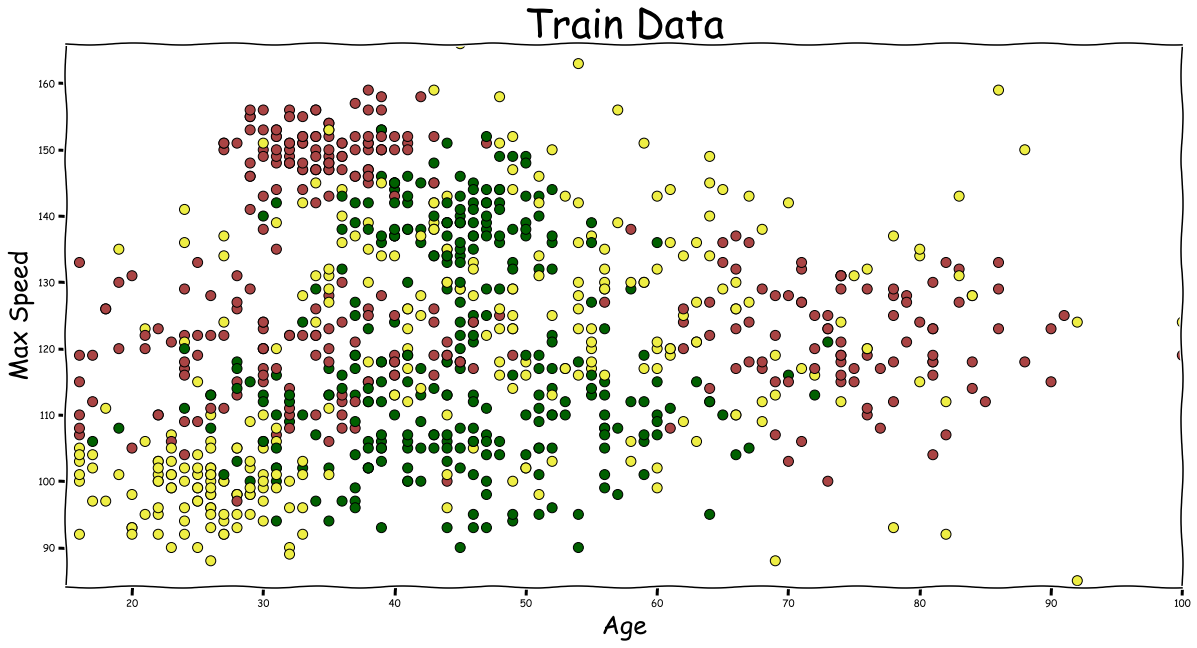

In [19]:
plotPrediction(None, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train, mesh=False,
                title="Train Data",
                fname='train.png')

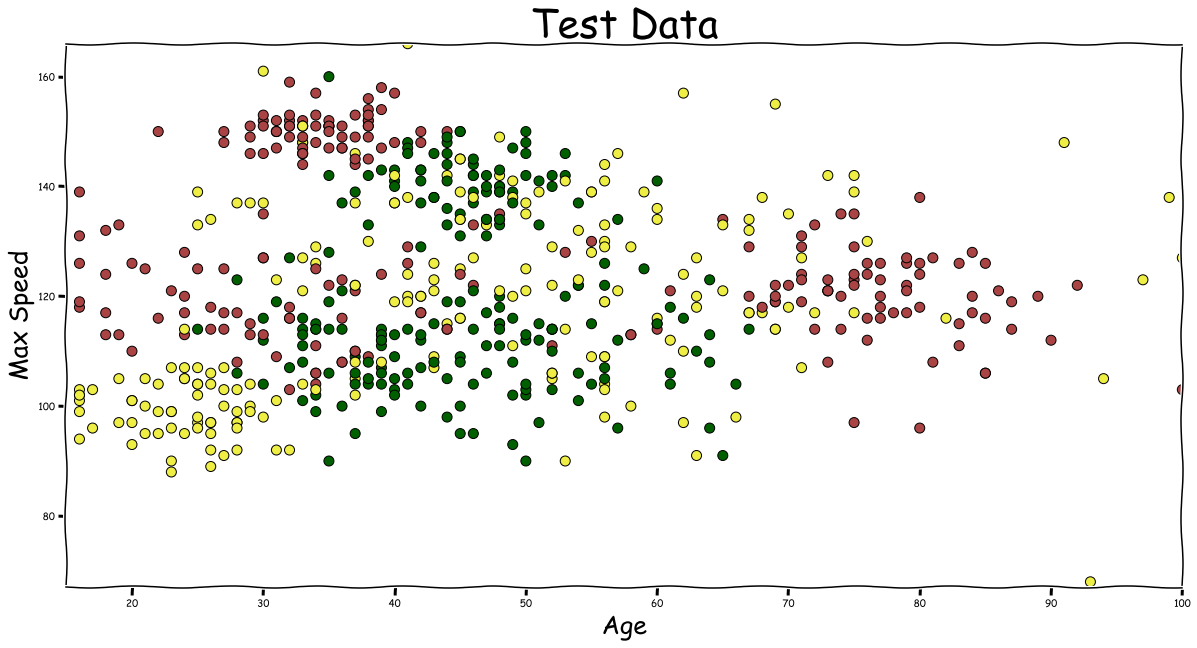

In [20]:
plotPrediction(None, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, mesh=False,
                title="Test Data",
                fname='test.png')

## KNN - Most basic learning strategy: Look at the neighbors to make a prediction for a sample yet unknown

In [21]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(1)

In [22]:
%time clf.fit(X_train_2_dim, y_train)

Wall time: 1e+03 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

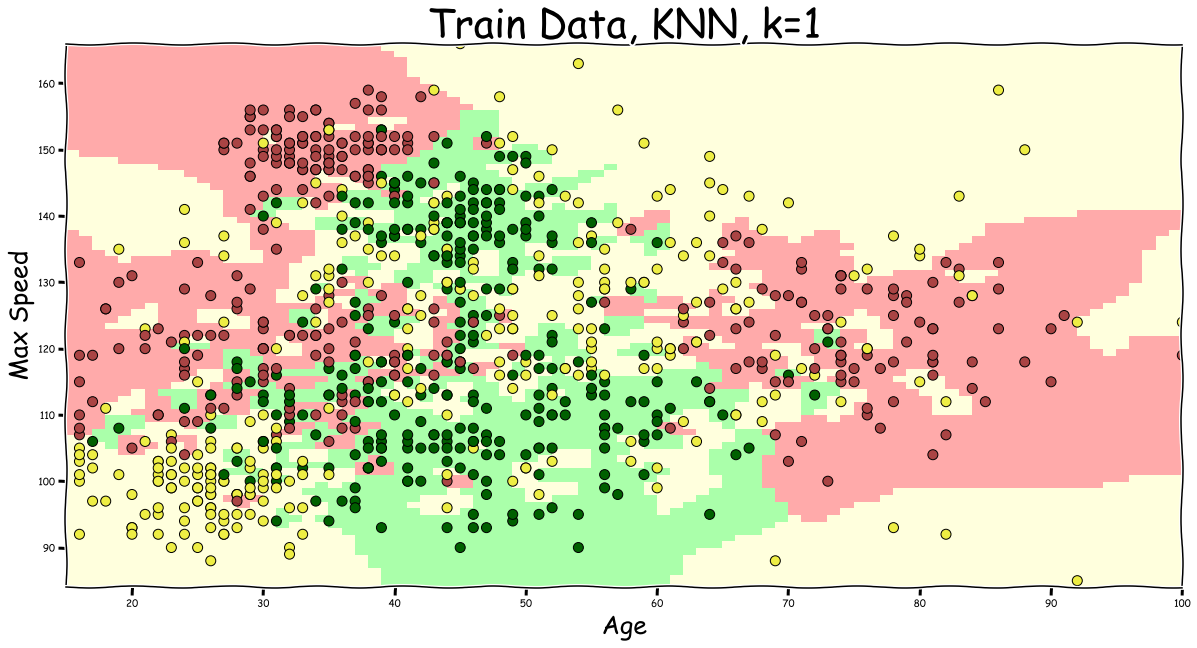

In [23]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=1",
                fname='knn1-train.png')

In [24]:
clf.score(X_train_2_dim, y_train)

0.9577777777777777

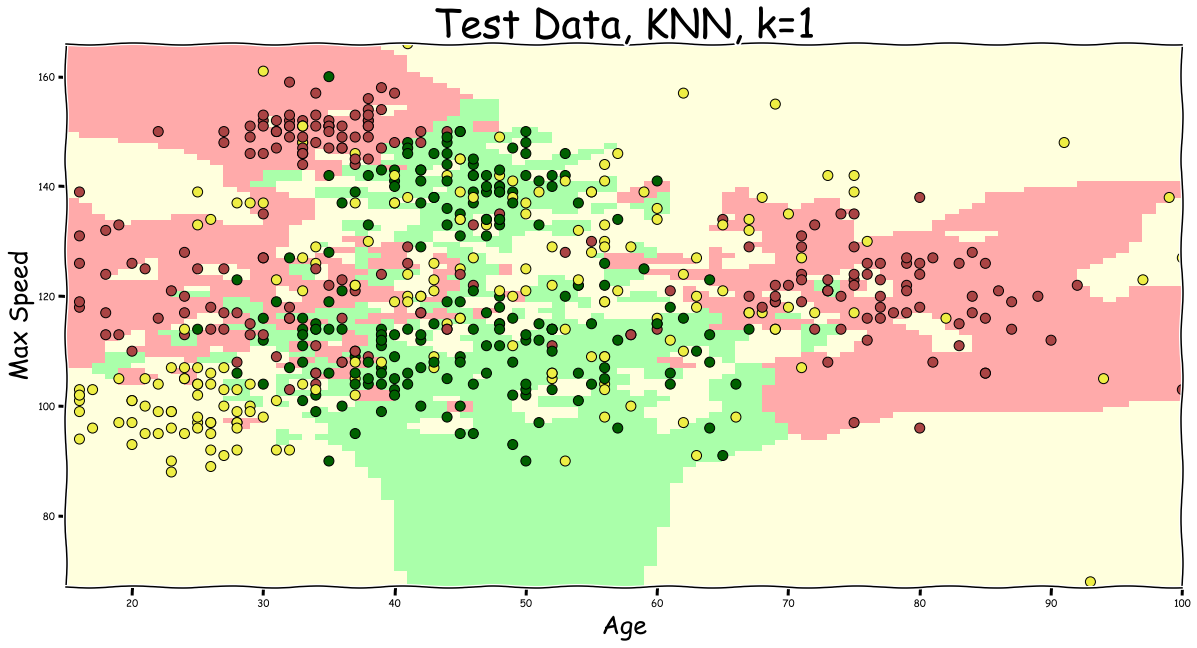

In [25]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=1",
                fname='knn1-test.png')

In [26]:
clf.score(X_test_2_dim, y_test)

0.5983333333333334

In [27]:
# http://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import cross_val_score

In [28]:
# cross_val_score?

Cross Validation splits the train data in different ways and performs a number of training runs (3 in this case) 

In [29]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
scores

array([0.59468439, 0.61666667, 0.62876254])

In [30]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.03)


# Exercise: Try to manually find a better k
* execute the noteboon up to this point
* change k based on your previous experiments
* what is the important value to check?

## Third important concept: Our objective is to make the best prediction for unknown samples. This is called generalization. If we perform well on knwon data, but less good on unknown data this is called overfitting. This is to be avoided. Measures taken to avoid overfitting are also known as _regularization_.

### In KNN we reduce overfitting by taking more neighbors into account

We can try what is the best number of numbers manually, but grid search does the same thing, only with less manual effort. This one tries the number of neighbors between 1 and 50

In [31]:
# KNeighborsClassifier?

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'] # are points that are nearer more important?
    }
clf = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

Wall time: 1.93 s


{'n_neighbors': 39, 'weights': 'uniform'}

In [33]:
clf = KNeighborsClassifier(n_neighbors=39, weights='uniform')
%time clf.fit(X_train_2_dim, y_train)

Wall time: 1e+03 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=39, p=2,
           weights='uniform')

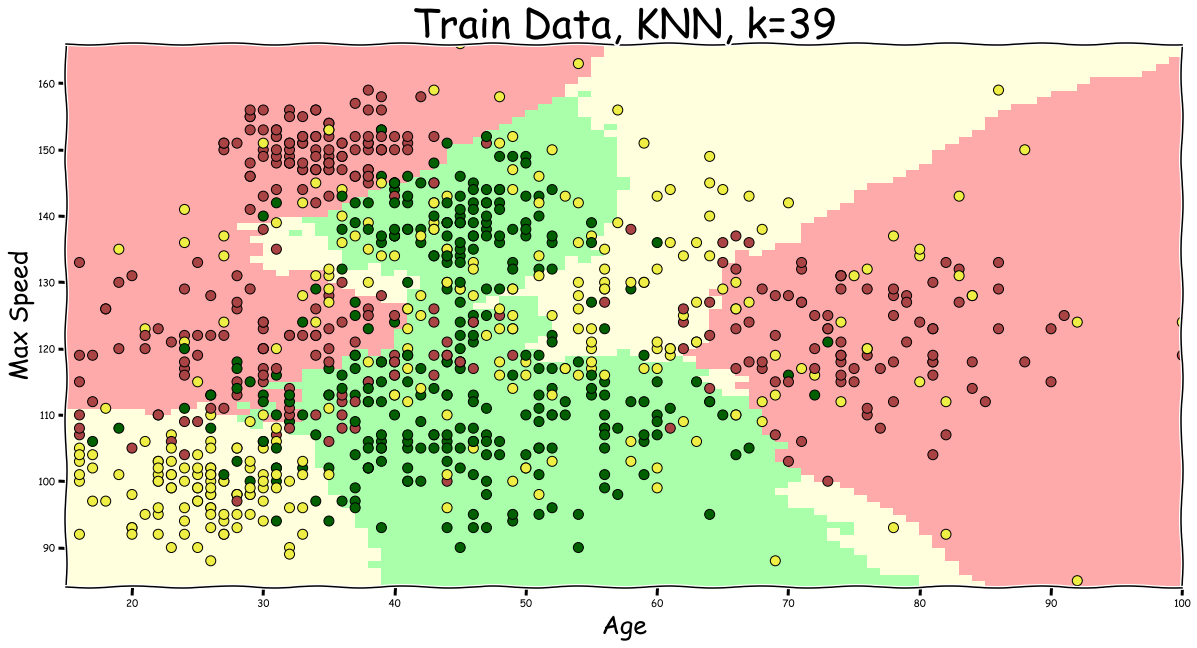

In [34]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, KNN, k=39")

### A rule of thumb: Smoother decision boundaries imply less overfitting

In [35]:
clf.score(X_train_2_dim, y_train)

0.6955555555555556

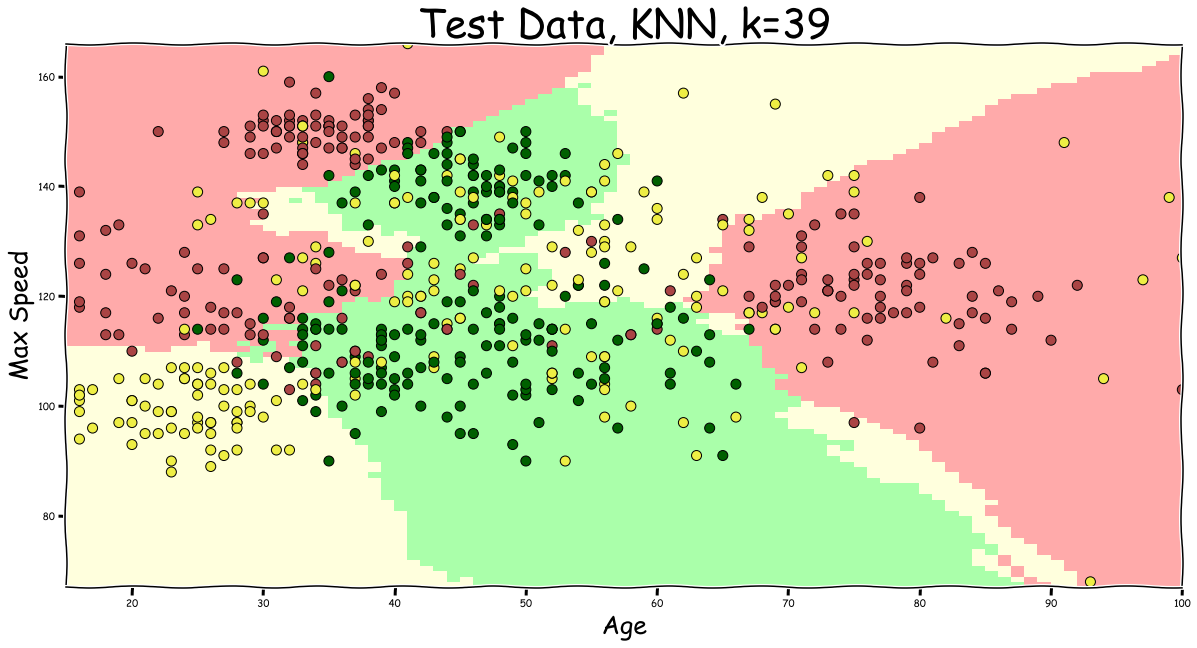

In [36]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN, k=39")

In [37]:
clf.score(X_test_2_dim, y_test)

0.7133333333333334

In [38]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
scores

array([0.6910299 , 0.70666667, 0.66889632])

In [39]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.69 (+/- 0.03)


## Descision Trees

* Another learning strategy, just like KNN is one
* Splits our data set on a certain variable
* Similar to what we have done in the manual classifier, but here the rules are actually learned

In [40]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
%time clf.fit(X_train_2_dim, y_train)

Wall time: 999 µs


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### How is the Decision Tree being Constructed?

We are using the CART algorithm:
* top-down split the set of examples into two new sets
* choose a variable and a value at each step that best splits our customer example
* terminal node when no further gain possible or regularization kicks in

<img src="https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/dt/cart.png">

http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

### What is the best split?

* assign a category to each node containing a certain set of samples
* use a metric (Gini or Entropy) to decide how good a node would be based on that category
* sum up weighted metric for both child nodes
* optimize the split for that summed metric

https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/


In [41]:
# we perform at most 20 splits of our data until we make a decision where the data point belongs

clf.tree_.max_depth

18

### Complete Decision Tree

<img src="https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/dt/dt-all.png">

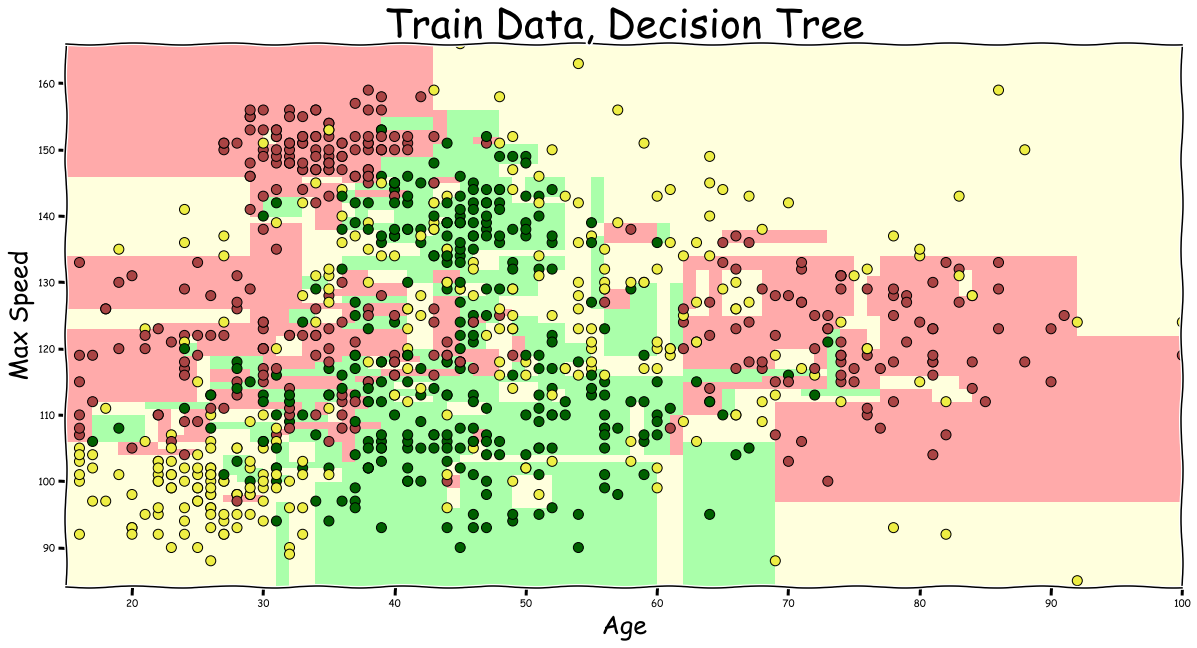

In [42]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Decision Tree",
                fname='dt-overfit-train.png')

In [43]:
clf.score(X_train_2_dim, y_train)

0.96

In [44]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
scores

array([0.56810631, 0.56666667, 0.62207358])

In [45]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.59 (+/- 0.05)


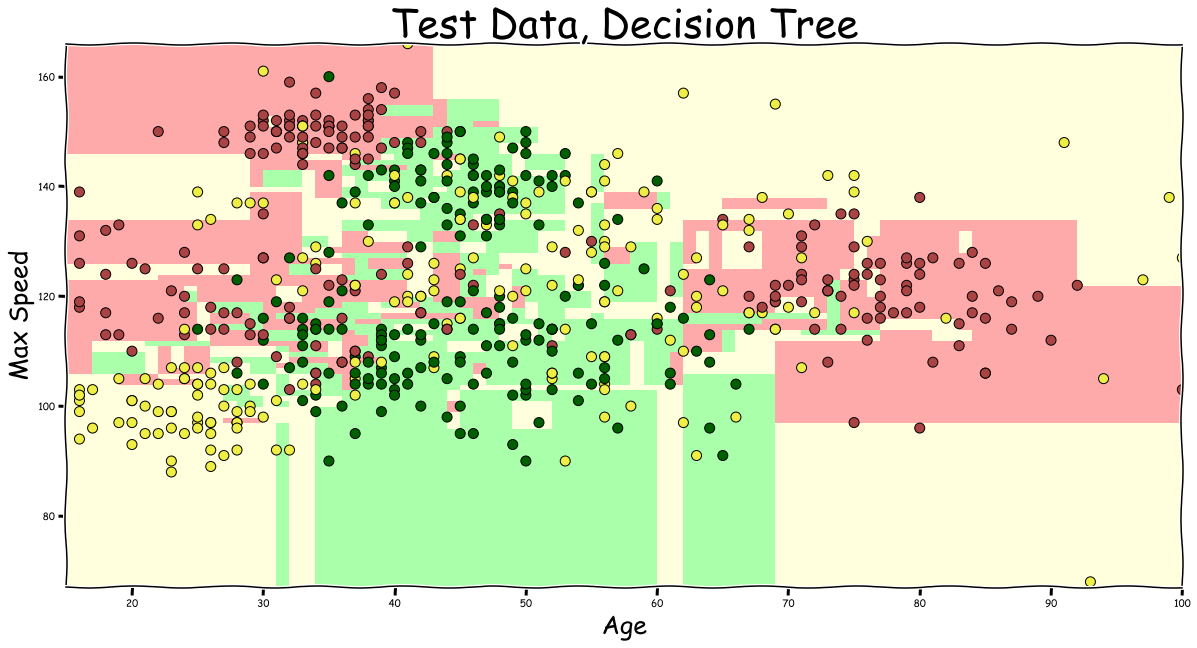

In [46]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree",
                fname='dt-overfit-test.png')

In [47]:
clf.score(X_test_2_dim, y_test)

0.595

We overfit heavily and need to change the relevant parameters of our tree
* its maximum number of spits (depth) - if there is no limit, we can make as many splits as it takes to perfectly match all train data (overfitting)
* how many samples we need at least for a leaf - if it is just one, we could perfectly fit all training data (overfitting)
* how many samples do we need to make another split - not as crucial as the other two, but can still limit overfitting

In [48]:
param_grid = {
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

Wall time: 2.6 s


{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}

In [49]:
clf = DecisionTreeClassifier(max_depth=6,
                              min_samples_leaf=3,
                              min_samples_split=2)
%time clf.fit(X_train_2_dim, y_train)

Wall time: 3 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [50]:
clf.tree_.max_depth

6

### Reduced Decision Tree

<img src="https://raw.githubusercontent.com/DJCordhose/ai/master/docs/img/dt/dt-lvl3.png">

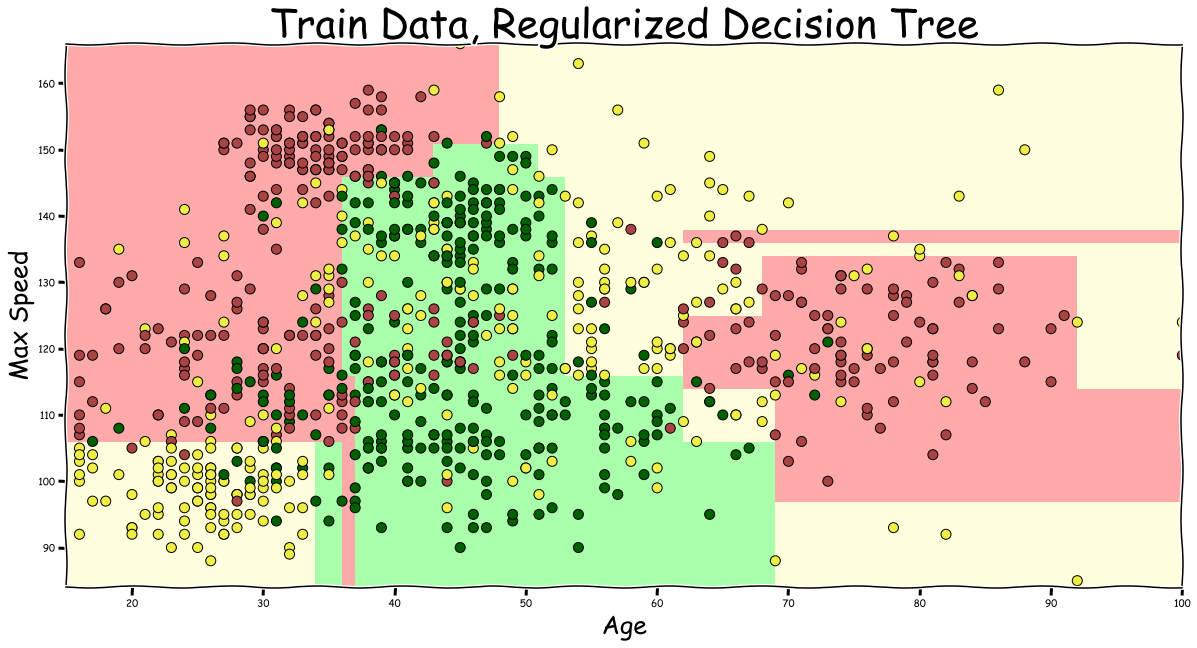

In [51]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Decision Tree",
                fname='dt-sweet-train.png')

In [52]:
clf.score(X_train_2_dim, y_train)

0.7444444444444445

In [53]:
scores = cross_val_score(clf, X_train_2_dim, y_train, n_jobs=-1)
scores

array([0.68438538, 0.67666667, 0.67558528])

In [54]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.68 (+/- 0.01)


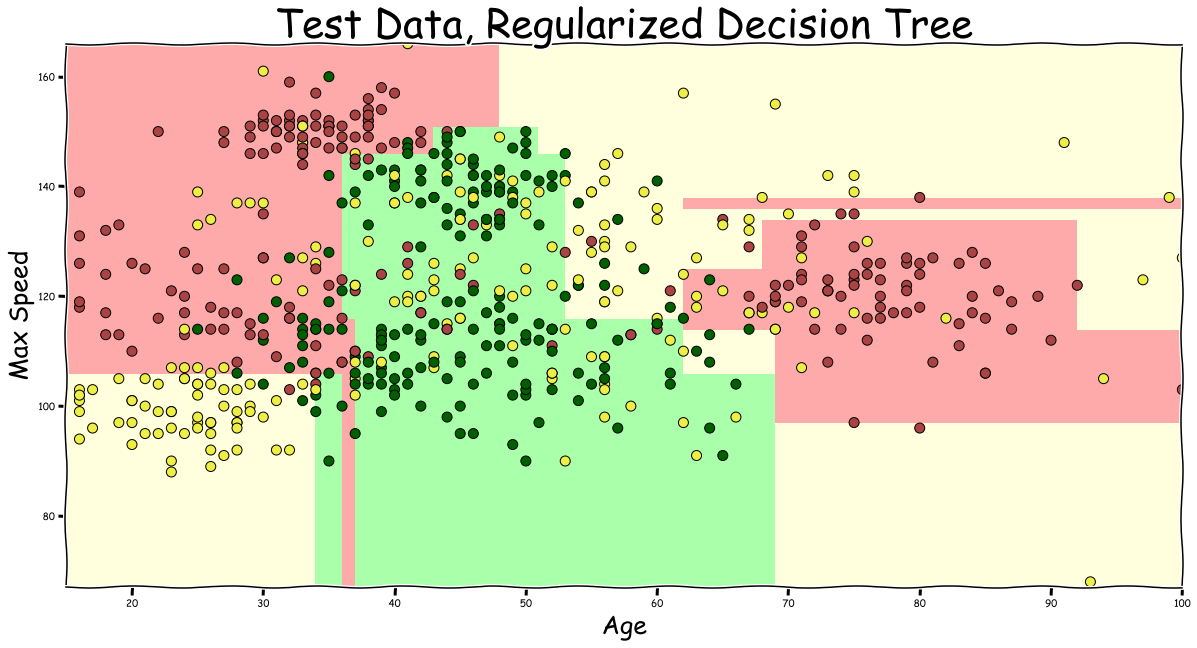

In [55]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Decision Tree",
                fname='dt-sweet-test.png')

In [56]:
clf.score(X_test_2_dim, y_test)

0.6833333333333333

## Random Forest
* We fight overfitting in decision trees with some success
* However, inherent to their nature, decision trees tend to overfit
* Random Forest is an ensemble technique that trains a number of simple decision trees and uses a majority vote over all of them for prediction
* While each decision tree still overfits using many of them softens this problems
* You still need to regularize the underlying decision trees
* sklearn has a default of 10 decision trees for random forest
* Random Forest is the swiss army knife of machine learning

In [57]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

Wall time: 110 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [58]:
clf.score(X_train_2_dim, y_train)

0.9344444444444444

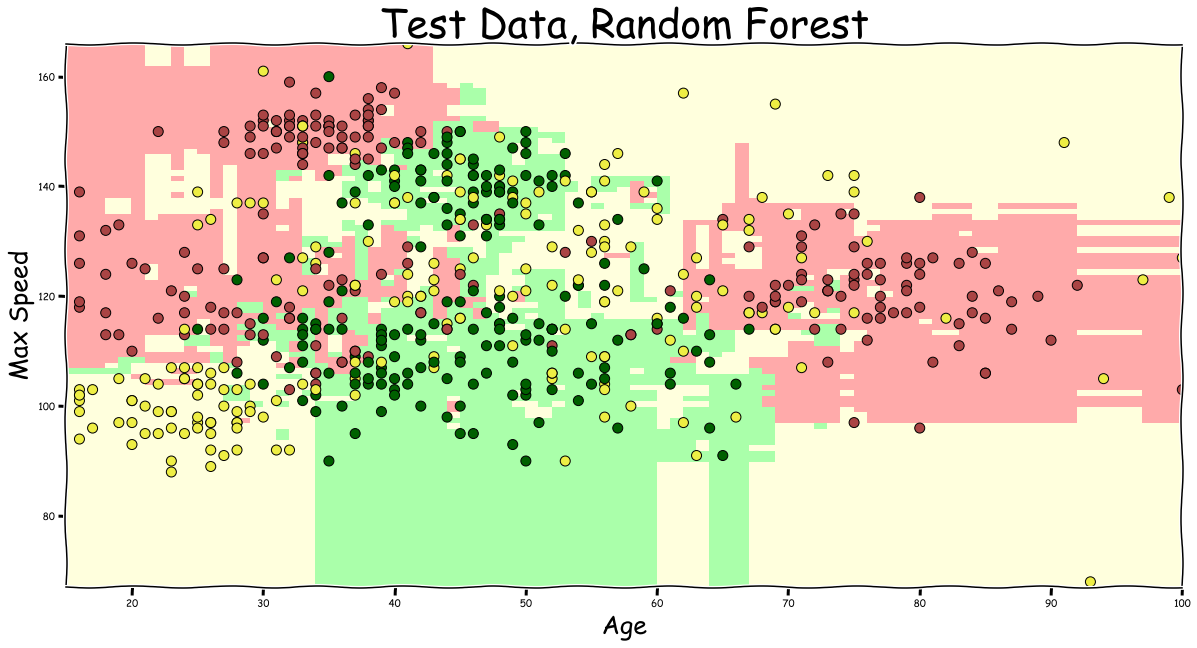

In [59]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Random Forest",
                fname='rf-overfit-train.png')

In [60]:
clf.score(X_test_2_dim, y_test)

0.645

In [61]:
# brute force grid search is far too expensive

param_grid = {
    'n_estimators': list(range(3,20)),
    'max_depth': list(range(2, 25)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11))
}
clf = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1)
# %time clf.fit(X_train_2_dim, y_train)
# clf.best_params_

Unfortunately, training random forest classifiers is more expensive than decision trees by the number of estimators it uses (10 in our case). This makes using a deterministic grid search over all parameters prohibitively expensive. We instead use a randomized search, that tries 100 different values and we hope to find the best here.

In [62]:
# http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(3,20),
    "max_depth": randint(2, 25),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

clf = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=1000, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

Wall time: 45.1 s


{'max_depth': 6,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 19}

In [63]:
# parameters might vary a bit with each run, because it is a random search
clf = RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=7, n_estimators=12, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)

Wall time: 112 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
clf.score(X_train_2_dim, y_train)

0.7422222222222222

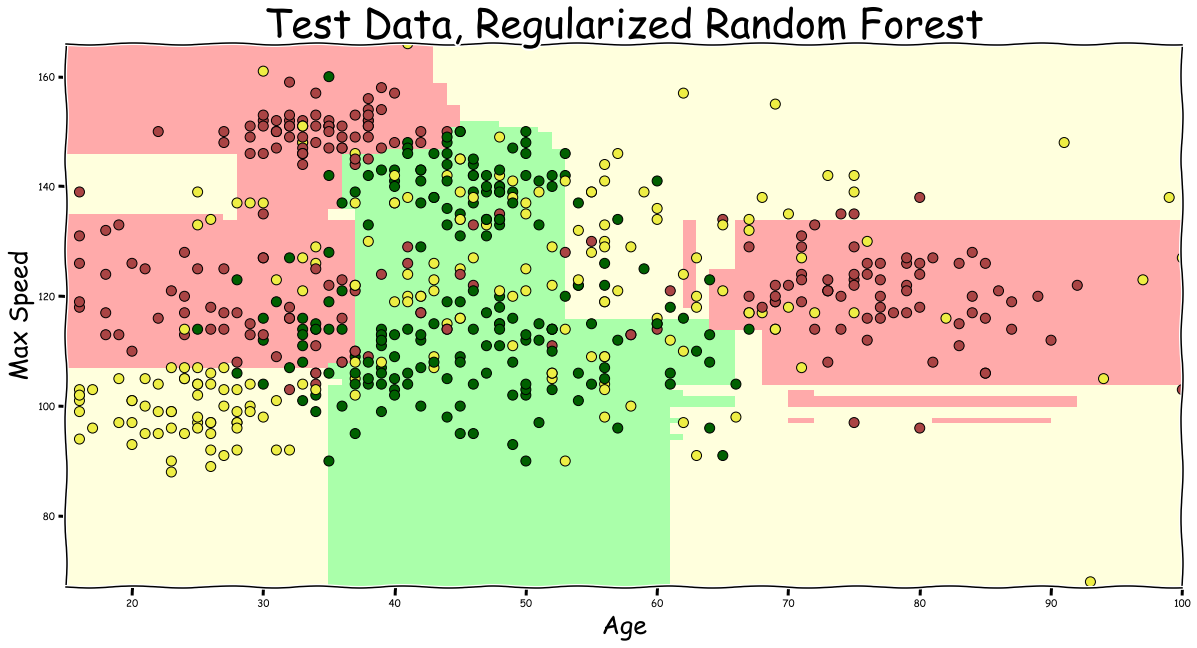

In [65]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Random Forest",
                fname='rf-sweet-test.png')

In [66]:
clf.score(X_test_2_dim, y_test)

0.6916666666666667

# Exercise: Try to optimize on the parameters
* we only have a good guess about the optimal parameters here
* re-run the ramdomized search and try to get better results
* you can also try the grid seach with a limited search range 

## Support Vector Machines (SVM)
* SVMs used to be the hot stuff before neural networks stole the show
* SVMs choose a small number of data points to decide where to draw the decision boundary, they are called the *support vectors*

In its base version SVMs can only use lines as decision boundaries. Let's see how well this works.

In [67]:
from sklearn.svm import SVC
clf = SVC(kernel='linear')
%time clf.fit(X_train_2_dim, y_train)

Wall time: 434 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [68]:
clf.score(X_train_2_dim, y_train)

0.4533333333333333

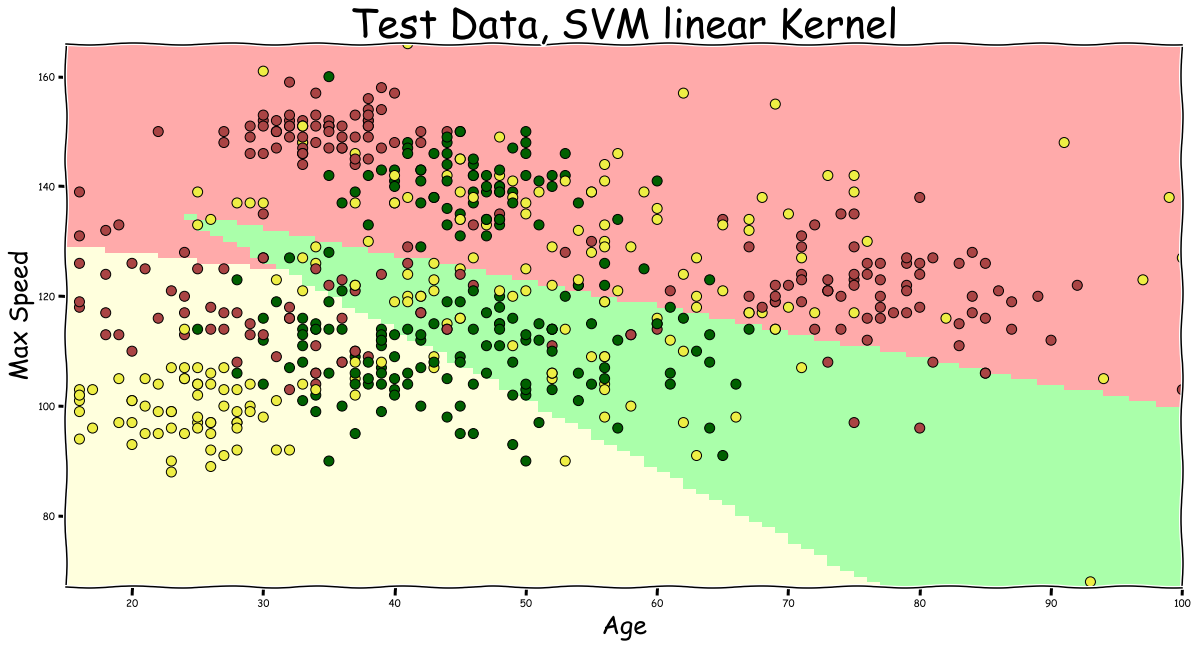

In [69]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM linear Kernel",
                fname='svm-underfit-linear-train.png')

#### SVM Kernels

* As we can see using lines only, we can not even fit the training data, this is called *underfitting*.
* For most realisitic examples we need something better called the 'kernel trick'
* We transform the original problem space into another that is separable by lines only
* Radial Base Functions 'rbf' can approximate any function and are trained to perform this transformation

In [70]:
from sklearn.svm import SVC
clf = SVC()
%time clf.fit(X_train_2_dim, y_train)

Wall time: 64 ms


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [71]:
clf.score(X_train_2_dim, y_train)

0.9055555555555556

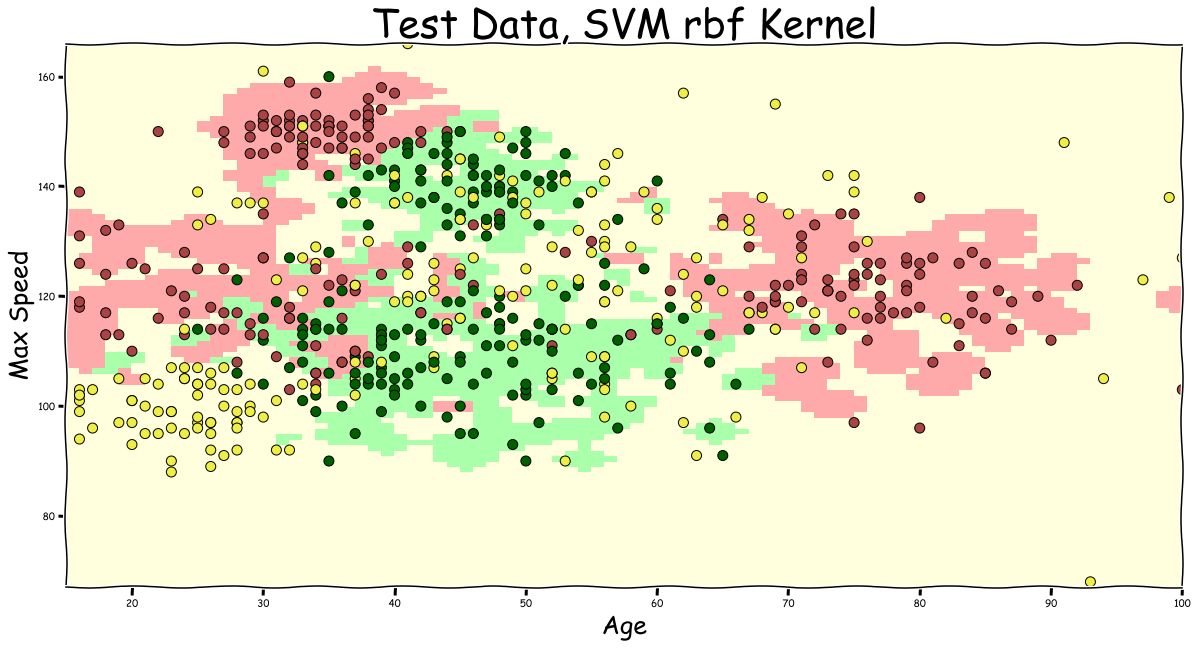

In [72]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM rbf Kernel",
                fname='svm-overfit-test.png')

In [73]:
clf.score(X_test_2_dim, y_test)

0.64

In [74]:
# SVC?

Again we strongly overfit and need to regularize our model. The two important parameters are
* C (Cost): decides how expensive it is to misclassify one of our support vectors, the smaller the more tolerant
* Gamma: the higher the more points remote from the support vectors influence where the decision boundaries go

Interactively experiment with C and Gamma: https://dash-gallery.plotly.host/dash-svm

In [75]:
param_grid = {
    'C': list(np.append(np.arange(0.1, 1.0, 0.1), np.arange(2, 10, 1))),
    'gamma': list(np.append(np.arange(0.001, 0.1, 0.0005), np.arange(.02, 1.0, 0.1))),
}
clf = GridSearchCV(SVC(), param_grid, n_jobs=-1)
%time clf.fit(X_train_2_dim, y_train)
clf.best_params_

Wall time: 48.6 s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 9.0, 'gamma': 0.001}

In [76]:
clf = SVC(C=9, gamma=0.001)
%time clf.fit(X_train_2_dim, y_train)

Wall time: 19 ms


SVC(C=9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [77]:
clf.score(X_train_2_dim, y_train)

0.7122222222222222

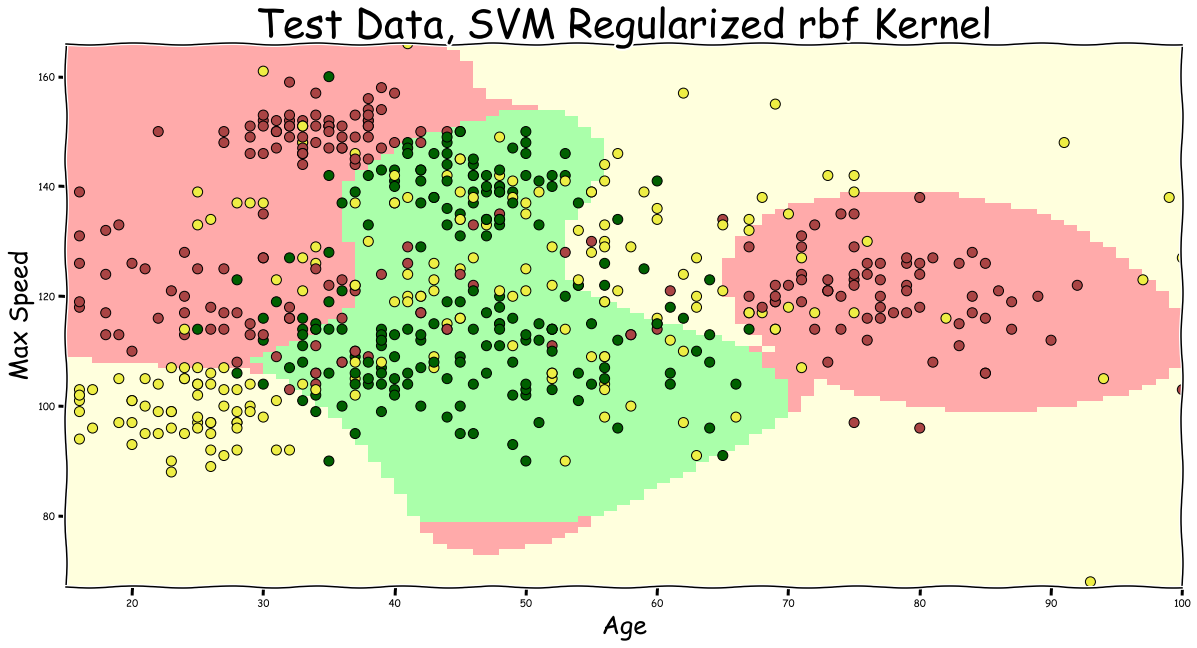

In [78]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, SVM Regularized rbf Kernel",
                fname='svm-reg-test.png')

In [79]:
clf.score(X_test_2_dim, y_test)

0.71

# Exercise: Improve Cost and Gamma
* use https://dash-gallery.plotly.host/dash-svm to get a better intuition for C and Gamma
* Change C and Gamme based on your intuition
* Can you do better than the results coming from the grid search?
* Why not?

## Neural Networks using TensorFlow and Keras Layers

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [80]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [81]:
# let's see what compute devices we have available, hopefully a GPU
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)
hello = tf.constant('Hello TF!')
print(sess.run(hello))

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0
b'Hello TF!'


In [82]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


## Neuron (aka node or unit)

A neuron takes a number of numerical inputs, multiplies each with a weight, sums up all weighted input and adds bias (constant) to that sum. From this it creates a single numerical output. For one input (one dimension) this would be a description of a line. For more dimensions this describes a hyper plane that can serve as a decision boundary. Typically, this output is transformed using an activation function which compresses the output to a value between 0 and 1 (sigmoid), or between -1 and 1 (tanh) or sets all negative values to zero (relu).

It is not really important to understand the details of a neural network. Practically how you configure them to form something more powerful is much more important. This, however, is still a very experimental domain, so there really is no conscise explanation and understanding how they work.

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/neuron.jpg'>

### From Neuron to Layer
* Neural Networks consist of artificial neurons you organize in layers
* each neuron is very simple, but, theoretically, having enough of them in a single layer can approximate any funtion
* practically, we use 2 or 3 layers, as this has turned out to work well
* the more neurons and the more layers you use the longer the network takes to train
* neural networks often are no longer approachable using cross validation and grid search to find suitable hyper parameters

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/encoding3.jpg'>

We start with two hidden layers each having 500 neurons

In [83]:
# tf.keras.layers.Dense?

In [84]:
from tensorflow.keras.layers import Dense

model = keras.Sequential()

model.add(Dense(units=500, name='hidden1', activation='tanh', input_dim=2))
model.add(Dense(units=500, name='hidden2', activation='tanh'))

model.add(Dense(3, name='softmax', activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


If you do not train for too long, even without any further regularization this network will not overfit by too much, but look at how strange the decision boundaries look like

## Validation Split

As test evaluation is a one-shot test, we again separate data for continues validation

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/generalization2.jpg'>

We can not use cross validation as each training run takes far too much time

In [85]:
BATCH_SIZE=1000
EPOCHS = 2000

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('keras-model.epoch-{epoch:02d}-val_loss-{val_loss:.2f}.hdf5',
#                                                 verbose = 1, save_best_only=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('keras-model.hdf5', verbose = 1, save_best_only=True)

# %time model.fit(X_train_2_dim, y_train_categorical, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[checkpoint, early_stopping])
%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

Wall time: 15.9 s


In [86]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

900/900 [==============================] - 0s 2us/step


0.7311111092567444

In [87]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

600/600 [==============================] - 0s 3us/step


0.7066666483879089

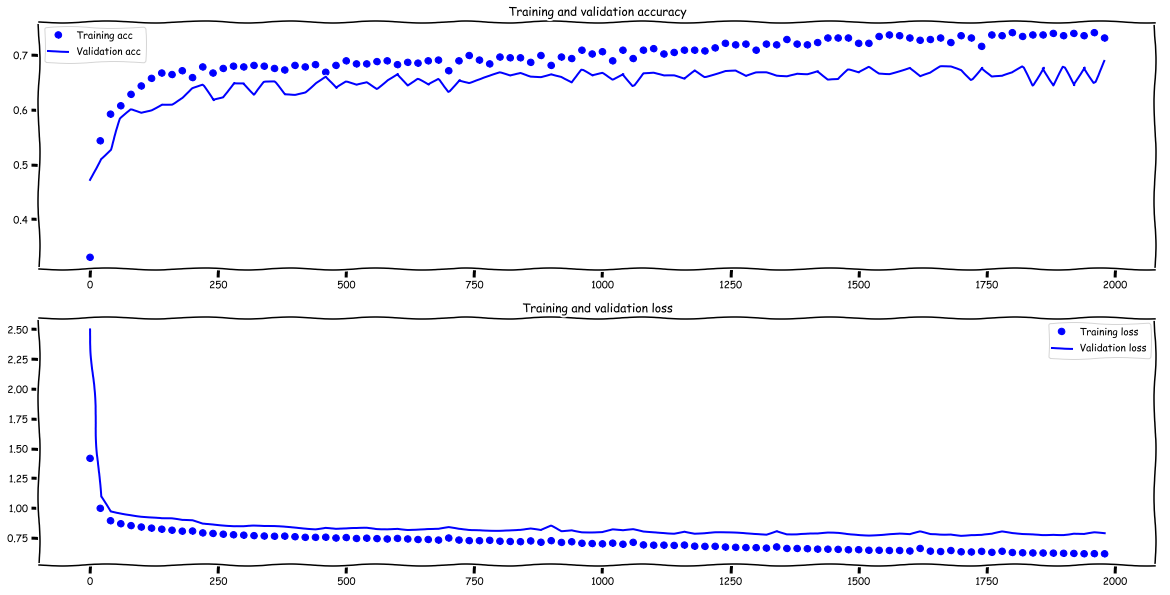

In [88]:
plot_history(history)

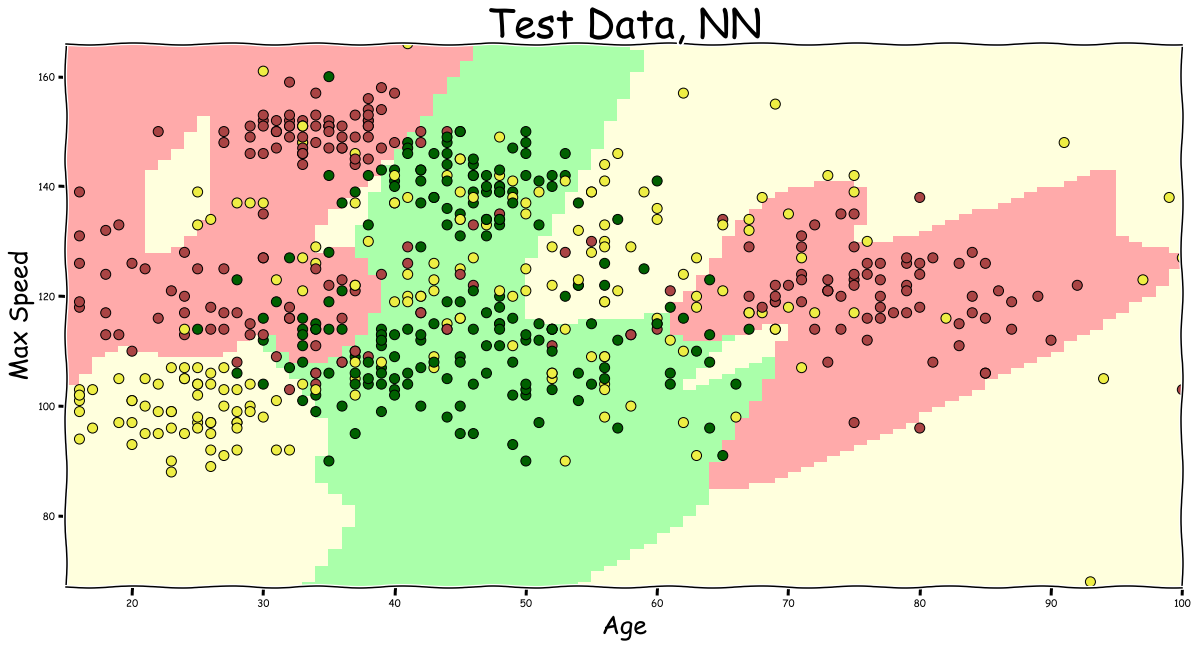

In [89]:
plot_keras_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN")

Even though scores do not look too bad, decision boundaries tell us, this is not a good result. We have several means of regularization for neural networks and we use a combination of them as described below.

### We have several means of regularization

 _We use a combination of them:_
- reduce capacity of model
- dropout
- batch normalization
- change activation to relu for faster training
- reduce amount of training cycles

## Dropout explained in a funny way

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/dropout-smerty.jpg'>

https://twitter.com/Smerity/status/980175898119778304

### An experimental approach:
- keep adding regularization to make test and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have gone too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data
- if you want to use batch normalization place it between raw output of neuron and activation function    

In [90]:
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout

# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras
# regularisation:
# - dropout
# - batch normalization
# - reduce capacity of model

dropout = 0.6
model = keras.Sequential()

model.add(Dense(100, name='hidden1', input_dim=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(3, name='softmax', activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               300       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
__________

In [91]:
BATCH_SIZE=1000
EPOCHS = 3000

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, verbose=1)

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping], verbose=0)

Epoch 02643: early stopping
Wall time: 23.9 s


In [92]:
# use the best model
# from keras.models import load_model

# model = load_model('keras-model.hdf5')

In [93]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

900/900 [==============================] - 0s 0us/step


0.7133333086967468

In [94]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

600/600 [==============================] - 0s 0us/step


0.6933333277702332

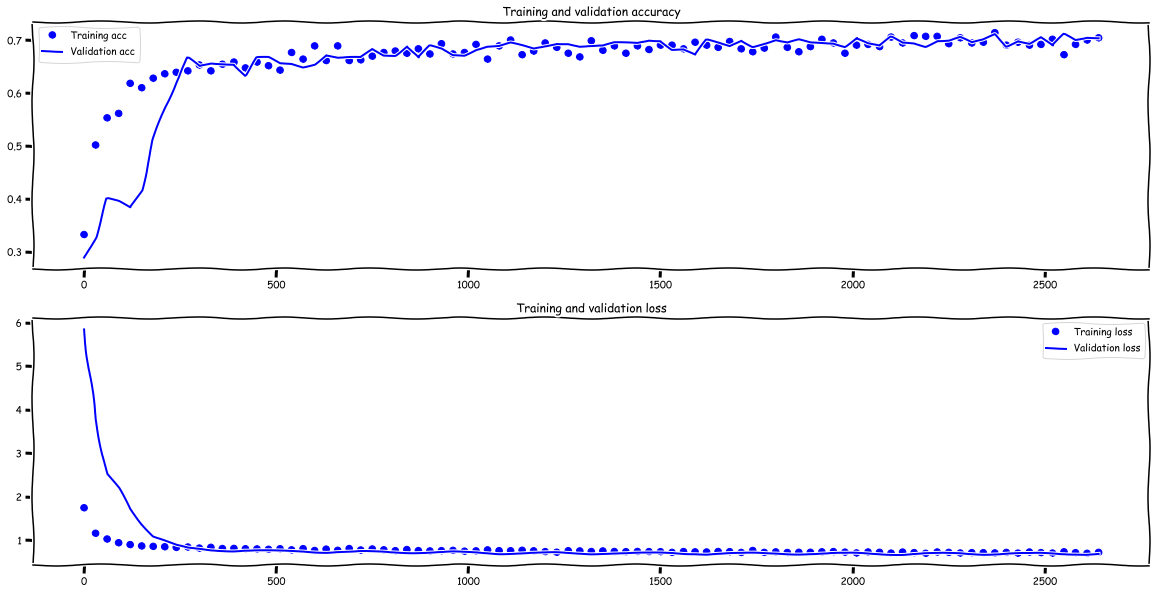

In [95]:
plot_history(history)

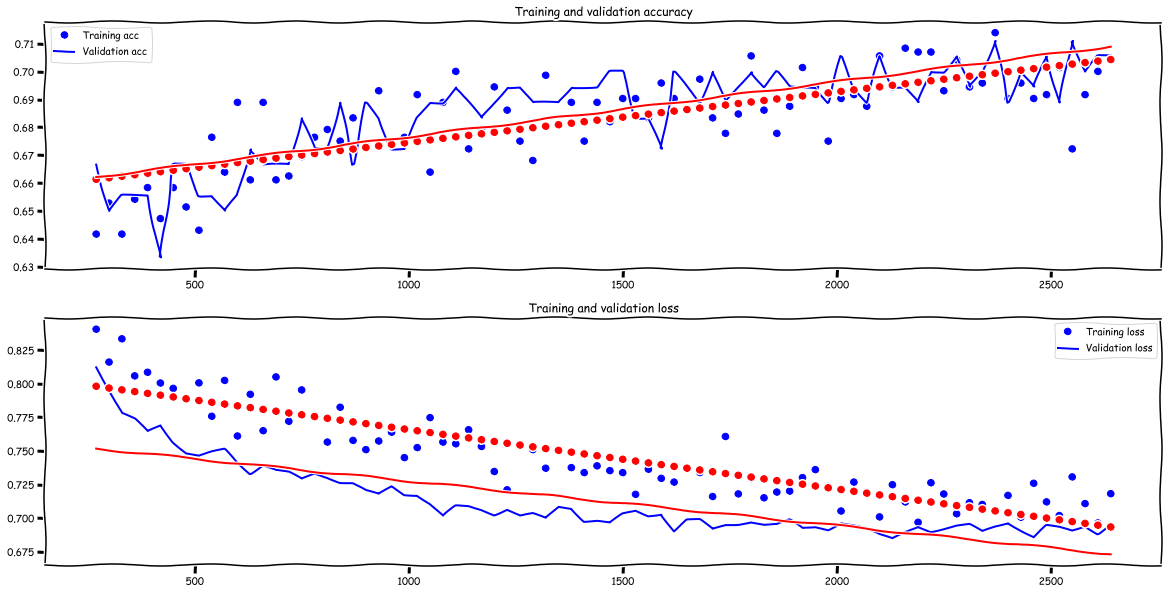

In [96]:
plot_history(history, init_phase_samples=250, plot_line=True)

### Scores around 70% look good now, there might even be a bit more potential here, but we are not going after a final percent here

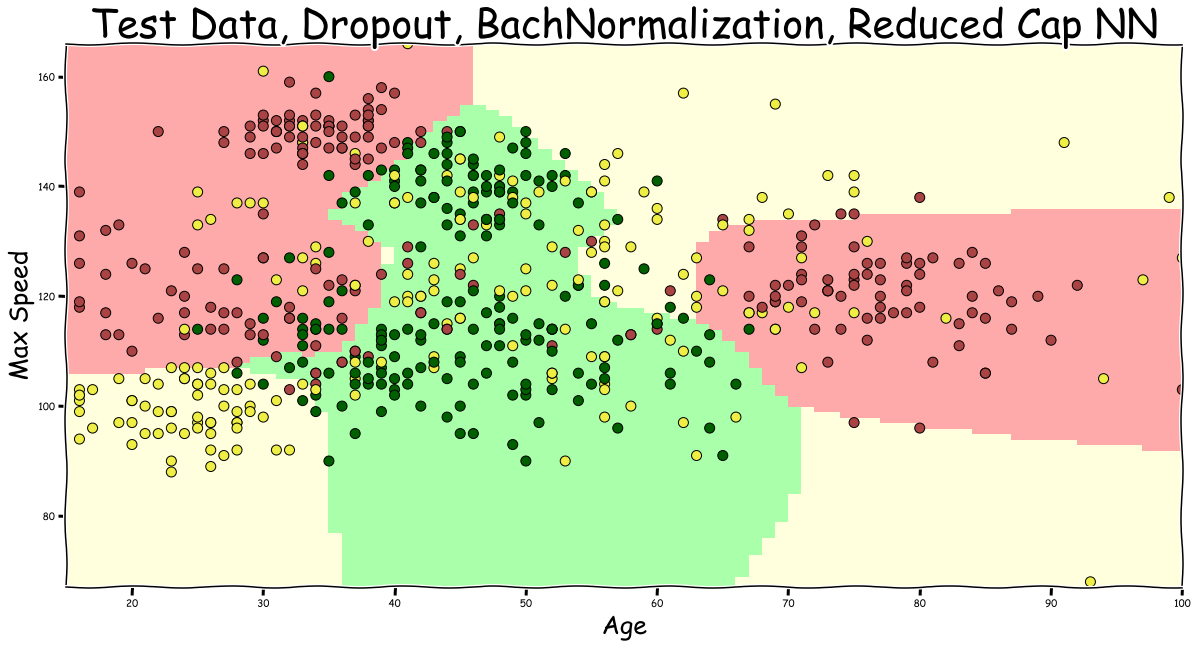

In [97]:
plot_keras_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Dropout, BachNormalization, Reduced Cap NN",
                fname='nn-reg-test.png')

### It is surprising how smooth and very similar these decision boundaries are to the ones created by SVM